In [1]:
from app.models import Video
import hwang, storehouse
import numpy as np
import matplotlib.pyplot as plt
import os
from multiprocessing import Pool
from tqdm import tqdm

backend = storehouse.StorageBackend.make_from_config(
    storehouse.StorageConfig.make_gcs_config('esper'))

def for_hwang(video_path):
    f = storehouse.RandomReadFile(backend, video_path)
    # dec = hwang.Decoder(storehouse.RandomReadFile(backend, video.path))
    dec = hwang.Decoder(f)
    return dec

def get_height(video_path_num_frames):
    video_path = video_path_num_frames[0]
    num_frames = video_path_num_frames[1]
    frame_nums = [1000, 10000, 20000]
    dec = for_hwang(video_path)
    imgs = dec.retrieve([f for f in frame_nums if f < num_frames])
    heights = np.sum(np.sum(imgs, axis=(2,3)) != 0, axis=1)
    heights[heights < 100] = 10000
    return min(heights)

In [2]:
output_folder = '/app/data/frame_heights'
os.makedirs(output_folder, exist_ok=True)

In [111]:
total_videos = Video.objects.count()
step_size = 500
total_videos

257031

In [4]:
ranges = range(38000, total_videos, step_size)

In [5]:
list(ranges)[0]

38000

In [ ]:
successful_r = []
for r in tqdm(ranges):
    p = Pool(64)
    min_r = r
    max_r = r + 500
    paths_and_frames = [
        (video.path, video.num_frames, video.id)
        for video in Video.objects.filter(id__gte=min_r, id__lt=max_r).order_by('id')
    ]
    res = p.map_async(get_height, paths_and_frames)
    try:
        heights = res.get(timeout = 60)
        heights_and_ids = [
            (vid_id, height)
            for height, (path, num_frames, vid_id) in zip(heights, paths_and_frames)
        ]
        with open(os.path.join(output_folder,
                               '{:06d}-{:06d}.txt'.format(min_r, max_r)), 'w') as f:
            for vid_id, height in heights_and_ids:
                f.write('{}\t{}\n'.format(vid_id, height))
        successful_r.append(r)
    except:
        pass
    finally:
        p.terminate()
        p.join()

 31%|████████████████████████████████████████████████████████████▌                                                                                                                                     | 137/439 [1:15:29<2:59:01, 35.57s/it]

# Figure out which video ranges were successful

In [8]:
ranges = range(0, total_videos, step_size)

In [9]:
failed_r = []
for r in ranges:
    min_r = r
    max_r = r + 500
    filename = os.path.join(output_folder,
                            '{:06d}-{:06d}.txt'.format(min_r, max_r))
    if not os.path.exists(filename):
        failed_r.append(r)

In [13]:
for r in tqdm(failed_r):
    for change in range(0, 500, 100):
        p = Pool(64)
        min_r = r + change
        max_r = r + change + 100
        paths_and_frames = [
            (video.path, video.num_frames, video.id)
            for video in Video.objects.filter(id__gte=min_r, id__lt=max_r).order_by('id')
        ]
        res = p.map_async(get_height, paths_and_frames)
        try:
            heights = res.get(timeout = 30)
            heights_and_ids = [
                (vid_id, height)
                for height, (path, num_frames, vid_id) in zip(heights, paths_and_frames)
            ]
            with open(os.path.join(output_folder,
                                   '{:06d}-{:06d}.txt'.format(min_r, max_r)), 'w') as f:
                for vid_id, height in heights_and_ids:
                    f.write('{}\t{}\n'.format(vid_id, height))
            successful_r.append(r)
        except:
            pass
        finally:
            p.terminate()
            p.join()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [1:27:38<00:00, 55.73s/it]


# Check video ranges again

In [18]:
sorted(os.listdir(output_folder))

['.ipynb_checkpoints',
 '000000-000500.txt',
 '000500-000600.txt',
 '000700-000800.txt',
 '000800-000900.txt',
 '001000-001100.txt',
 '001100-001200.txt',
 '001200-001300.txt',
 '001300-001400.txt',
 '001400-001500.txt',
 '001500-002000.txt',
 '002000-002500.txt',
 '002500-003000.txt',
 '003000-003500.txt',
 '003500-004000.txt',
 '004000-004500.txt',
 '004500-005000.txt',
 '005000-005100.txt',
 '005100-005200.txt',
 '005200-005300.txt',
 '005400-005500.txt',
 '005500-006000.txt',
 '006000-006500.txt',
 '006500-007000.txt',
 '007000-007500.txt',
 '007600-007700.txt',
 '007700-007800.txt',
 '007900-008000.txt',
 '008000-008500.txt',
 '008500-009000.txt',
 '009000-009500.txt',
 '009500-010000.txt',
 '010000-010500.txt',
 '010500-010600.txt',
 '010600-010700.txt',
 '010700-010800.txt',
 '010900-011000.txt',
 '011000-011100.txt',
 '011100-011200.txt',
 '011300-011400.txt',
 '011400-011500.txt',
 '011500-012000.txt',
 '012000-012500.txt',
 '012500-012600.txt',
 '012700-012800.txt',
 '012800-

In [22]:
video_heights = []
for file in sorted(os.listdir(output_folder)):
    if not file[0].isdigit():
        continue
    with open(os.path.join(output_folder, file), 'r') as f:
        for line in f.readlines():
            video_id = int(line.split('\t')[0].strip())
            height = int(line.split('\t')[1].strip())
            video_heights.append((video_id, height))

In [23]:
len(video_heights)

246531

In [31]:
successful_ids = set([video_id for video_id, height in video_heights])

In [28]:
all_ids = sorted(
    [vid.id for vid in Video.objects.all()]
)

In [32]:
failed_ids = [vid_id for vid_id in all_ids if vid_id not in successful_ids]

In [33]:
len(failed_ids)

10500

In [37]:
corrupted_ids = set([vid.id for vid in Video.objects.filter(corrupted=True)])

# Chunk again, no corrupted

In [40]:
import pickle

In [38]:
failed_non_corrupted = [vid_id for vid_id in failed_ids if vid_id not in corrupted_ids]

In [43]:
with open(os.path.join(output_folder, 'failed_non_corrupted.pkl'), 'wb') as f:
    pickle.dump(failed_non_corrupted, f)

In [46]:
ranges = range(0, len(failed_non_corrupted), 100)
for r in tqdm(ranges):
    p = Pool(64)
    min_r = r
    max_r = r + 100
    video_ids = failed_non_corrupted[min_r:max_r]
    paths_and_frames = [
        (video.path, video.num_frames, video.id)
        for video in Video.objects.filter(id__in=video_ids).order_by('id')
    ]
    res = p.map_async(get_height, paths_and_frames)
    try:
        heights = res.get(timeout = 30)
        heights_and_ids = [
            (vid_id, height)
            for height, (path, num_frames, vid_id) in zip(heights, paths_and_frames)
        ]
        with open(os.path.join(output_folder,
                               'failed_non_corrupted_{:06d}-{:06d}.txt'.format(
                                   min_r, max_r)), 'w') as f:
            for vid_id, height in heights_and_ids:
                f.write('{}\t{}\n'.format(vid_id, height))
        successful_r.append(r)
    except:
        pass
    finally:
        p.terminate()
        p.join()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 105/105 [51:40<00:00, 28.35s/it]


# Check again...

In [49]:
video_heights = []
for file in sorted(os.listdir(output_folder)):
    if 'txt' not in file:
        continue
    with open(os.path.join(output_folder, file), 'r') as f:
        for line in f.readlines():
            video_id = int(line.split('\t')[0].strip())
            height = int(line.split('\t')[1].strip())
            video_heights.append((video_id, height))

In [50]:
len(video_heights)

247031

In [51]:
successful_ids = set([video_id for video_id, height in video_heights])

In [52]:
all_ids = sorted(
    [vid.id for vid in Video.objects.filter(corrupted=False).all()]
)

In [53]:
failed_ids = [vid_id for vid_id in all_ids if vid_id not in successful_ids]

In [54]:
len(failed_ids)

9977

# Output what we have so far

In [56]:
import json

In [58]:
video_heights_output = [
    {'id': video_id, 'height': height}
    for video_id, height in video_heights
]

In [60]:
with open(os.path.join(output_folder, 'video_heights.json'), 'w') as f:
    json.dump(video_heights_output, f)

# Stragglers

In [61]:
remaining_paths_and_frames = [
    (video.path, video.num_frames, video.id)
    for video in Video.objects.filter(id__in=failed_ids).order_by('id')
]

In [85]:
output_f = open(os.path.join(output_folder, 'stragglers.txt'), 'w')
remaining_heights_video_ids = []
for path_frame in tqdm(remaining_paths_and_frames):
    p = Pool(1)
    res = p.apply_async(get_height, (path_frame,))
    try:
        height = res.get(timeout = 2)
        remaining_heights_video_ids.append((path_frame[2], height))
        output_f.write('{}\t{}\n'.format(path_frame[2], height))
    except:
        pass
    finally:
        p.terminate()
        p.join()
        
output_f.close()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9977/9977 [5:14:38<00:00,  1.80s/it]


In [86]:
len(remaining_heights_video_ids)

5560

In [87]:
successful_remaining_video_ids = set([
    video_id
    for video_id, height in remaining_heights_video_ids
])

# Long Stragglers

In [88]:
remaining_paths_and_frames_long_straggler = [
    (path, nframes, vid_id)
    for path, nframes, vid_id in remaining_paths_and_frames
    if vid_id not in successful_remaining_video_ids
]

In [ ]:
output_f = open(os.path.join(output_folder, 'long_stragglers.txt'), 'w')
remaining_heights_video_ids_long_straggler = []
for path_frame in tqdm(remaining_paths_and_frames_long_straggler):
    p = Pool(1)
    res = p.apply_async(get_height, (path_frame,))
    try:
        height = res.get(timeout = 20)
        remaining_heights_video_ids_long_straggler.append((path_frame[2], height))
        output_f.write('{}\t{}\n'.format(path_frame[2], height))
    except:
        pass
    finally:
        p.terminate()
        p.join()
        
output_f.close()

  4%|███████▍                                                                                                                                                                                           | 168/4417 [08:04<2:41:21,  2.28s/it]

In [95]:
print('Hi, done')

Hi, done


In [96]:
len(remaining_heights_video_ids_long_straggler)

4307

# Final JSON output

In [103]:
video_heights = []
for file in sorted(os.listdir(output_folder)):
    if 'txt' not in file:
        continue
    with open(os.path.join(output_folder, file), 'r') as f:
        for line in f.readlines():
            video_id = int(line.split('\t')[0].strip())
            height = int(line.split('\t')[1].strip())
            video_heights.append((video_id, height))

In [112]:
len(video_heights)

256898

In [113]:
video_heights_output = [
    {'id': video_id, 'height': height}
    for video_id, height in video_heights
]

In [114]:
len(video_heights_output)

256898

In [115]:
with open(os.path.join(output_folder, 'video_heights_all.json'), 'w') as f:
    json.dump(video_heights_output, f)

# Debugging

In [6]:
import matplotlib.pyplot as plt

In [70]:
from app.models import Video
import hwang, storehouse

backend = storehouse.StorageBackend.make_from_config(
    storehouse.StorageConfig.make_gcs_config('esper'))

def for_hwang(video_path):
    f = storehouse.RandomReadFile(backend, video_path)
    # dec = hwang.Decoder(storehouse.RandomReadFile(backend, video.path))
    dec = hwang.Decoder(f)
    return dec

In [108]:
path = 'tvnews/videos/CNNW_20150321_090000_CNNI_Simulcast.mp4'

In [98]:
path = Video.objects.get(id=55).path
path

'tvnews/videos/CNNW_20170713_040000_Anderson_Cooper_360.mp4'

In [109]:
dec = for_hwang(path)

In [110]:
imgs = dec.retrieve([1000, 10000, 20000])

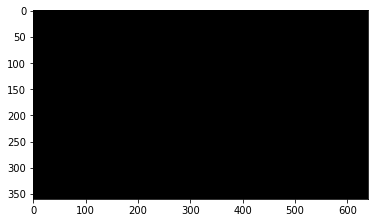

In [111]:
plt.imshow(imgs[0])

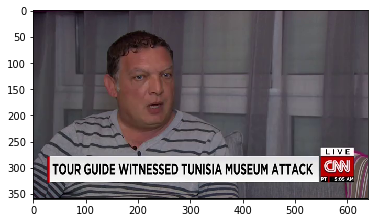

In [112]:
plt.imshow(imgs[1])

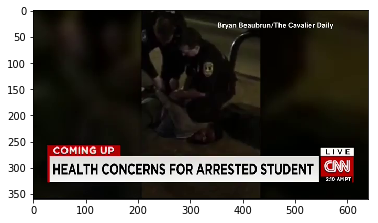

In [113]:
plt.imshow(imgs[2])

In [35]:
imgs[2].shape

(480, 640, 3)

In [38]:
import numpy as np

In [40]:
np.sum(imgs[2][0,:,:])

0

In [52]:
for img in imgs:
    print(np.count_nonzero(np.sum(img, axis=(1,2))))

392
386
384


In [63]:
estimates = np.sum(np.sum(imgs, axis=(2,3)) != 0, axis=1)

In [64]:
estimates[estimates < 100] = 10000

In [65]:
min(estimates)

384

In [68]:
videos = Video.objects.filter(id__lt = 10)

In [74]:
from tqdm import tqdm

In [77]:
frame_nums = [1000, 10000, 20000]

In [78]:
for video in tqdm(videos):
    dec = for_hwang(video.path)
    num_frames = video.num_frames
    imgs = dec.retrieve([f for f in frame_nums if f < num_frames])
    height = min(np.sum(np.sum(imgs, axis=(2,3)) != 0, axis=1))
    # print(height)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:12<00:00,  1.46s/it]


In [76]:
video.num_frames

219414

In [82]:
Video.objects.count()

257031

In [147]:
from app.models import Video
import hwang, storehouse
import numpy as np

backend = storehouse.StorageBackend.make_from_config(
    storehouse.StorageConfig.make_gcs_config('esper'))

def for_hwang(video_path):
    f = storehouse.RandomReadFile(backend, video_path)
    # dec = hwang.Decoder(storehouse.RandomReadFile(backend, video.path))
    dec = hwang.Decoder(f)
    return dec

def get_height(video_path_num_frames):
    video_path = video_path_num_frames[0]
    num_frames = video_path_num_frames[1]
    dec = for_hwang(video_path)
    imgs = dec.retrieve([f for f in frame_nums if f < num_frames])
    heights = np.sum(np.sum(imgs, axis=(2,3)) != 0, axis=1)
    heights[heights < 100] = 10000
    return min(heights)

In [148]:
from multiprocessing import Pool

In [149]:
p = Pool(32)

Process ForkPoolWorker-229:
Process ForkPoolWorker-174:
Process ForkPoolWorker-223:
Process ForkPoolWorker-202:
Process ForkPoolWorker-191:
Process ForkPoolWorker-215:
Process ForkPoolWorker-233:
Process ForkPoolWorker-180:
Process ForkPoolWorker-172:
Process ForkPoolWorker-186:
Process ForkPoolWorker-205:
Process ForkPoolWorker-227:
Process ForkPoolWorker-176:
Process ForkPoolWorker-194:
Process ForkPoolWorker-225:
Process ForkPoolWorker-221:
Process ForkPoolWorker-175:
Process ForkPoolWorker-201:
Process ForkPoolWorker-216:
Process ForkPoolWorker-230:
Process ForkPoolWorker-203:
Process ForkPoolWorker-178:
Process ForkPoolWorker-183:
Process ForkPoolWorker-189:
Process ForkPoolWorker-213:
Process ForkPoolWorker-208:
Process ForkPoolWorker-206:
Process ForkPoolWorker-214:
Process ForkPoolWorker-188:
Process ForkPoolWorker-210:
Process ForkPoolWorker-207:
Process ForkPoolWorker-196:
Process ForkPoolWorker-212:
Traceback (most recent call last):
Process ForkPoolWorker-195:
Traceback (mo

  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.5/multiprocessing/pool.py

KeyboardInterrupt
  File "/usr/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/usr/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/usr/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.5/multiprocessing/synchronize.py", line 9

  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
KeyboardInterrupt
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.5/multiprocessing/pool.py

  File "/usr/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
Process ForkPoolWorker-181:
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
KeyboardInterrupt
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/usr/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.5/multiproces

In [150]:
paths_and_frames = [
    (video.path, video.num_frames, video.id)
    for video in Video.objects.filter(id__lt=500).order_by('id')
]

In [151]:
heights = p.map(get_height, paths_and_frames)

In [152]:
heights_and_ids = [
    (vid_id, height)
    for height, (path, num_frames, vid_id) in zip(heights, paths_and_frames)
]

In [153]:
heights_and_ids

[(1, 360),
 (2, 360),
 (3, 360),
 (4, 360),
 (5, 360),
 (6, 360),
 (7, 360),
 (8, 360),
 (9, 360),
 (10, 360),
 (11, 360),
 (12, 360),
 (13, 360),
 (14, 360),
 (15, 360),
 (16, 360),
 (17, 360),
 (18, 360),
 (19, 386),
 (20, 360),
 (21, 360),
 (22, 359),
 (23, 360),
 (24, 360),
 (25, 360),
 (26, 360),
 (27, 360),
 (28, 360),
 (29, 360),
 (30, 359),
 (31, 360),
 (32, 360),
 (33, 360),
 (34, 360),
 (35, 360),
 (36, 360),
 (37, 360),
 (38, 360),
 (39, 360),
 (40, 360),
 (41, 360),
 (42, 360),
 (43, 360),
 (44, 360),
 (45, 360),
 (46, 360),
 (47, 360),
 (48, 360),
 (49, 360),
 (50, 360),
 (51, 360),
 (52, 360),
 (53, 360),
 (54, 360),
 (55, 360),
 (56, 360),
 (57, 360),
 (58, 360),
 (59, 360),
 (60, 360),
 (61, 360),
 (62, 360),
 (63, 360),
 (64, 360),
 (65, 360),
 (66, 360),
 (67, 360),
 (68, 358),
 (69, 360),
 (70, 360),
 (71, 360),
 (72, 360),
 (73, 360),
 (74, 360),
 (75, 360),
 (76, 360),
 (77, 360),
 (78, 360),
 (79, 360),
 (80, 360),
 (81, 360),
 (82, 360),
 (83, 360),
 (84, 360),
 